# United States Income

In this first example, we will look at Income and Night light intensity throughout the United States. The income data comes from the [American Community Survey](https://www.census.gov/geo/maps-data/data/tiger-data.html). We are interested in the [zip code level data](http://www2.census.gov/geo/tiger/TIGER_DP/2016ACS/ACS_2016_5YR_ZCTA.gdb.zip) and the associated [meta data](http://www2.census.gov/geo/tiger/TIGER_DP/2016ACS/Metadata/ZCTA_METADATA_2016.txt). After looking through the meta data, let's first look at the fields for population (B00001e1) and median household income (B19013e1).

The data are in a geodatabase, which the python library [fiona](http://toblerity.org/fiona/) can read, as well as many other data sources.

In [1]:
import fiona
import os
import pandas as pd
import seaborn as sns
from pprint import pprint
import matplotlib.pyplot as plt
%matplotlib inline
DATA_PATH = '/data/PyDataSpatialAnalysis/data'
ams_path = os.path.join(DATA_PATH, 'ACS_2016_5YR_ZCTA.gdb')

To see how the actual data are structured, we can first check layers are available:

In [2]:
fiona.listlayers(ams_path)

['X00_COUNTS',
 'X01_AGE_AND_SEX',
 'X02_RACE',
 'X03_HISPANIC_OR_LATINO_ORIGIN',
 'X04_ANCESTRY',
 'X05_FOREIGN_BORN_CITIZENSHIP',
 'X06_PLACE_OF_BIRTH',
 'X07_MIGRATION',
 'X08_COMMUTING',
 'X09_CHILDREN_HOUSEHOLD_RELATIONSHIP',
 'X10_GRANDPARENTS_GRANDCHILDREN',
 'X11_HOUSEHOLD_FAMILY_SUBFAMILIES',
 'X12_MARITAL_STATUS_AND_HISTORY',
 'X13_FERTILITY',
 'X14_SCHOOL_ENROLLMENT',
 'X15_EDUCATIONAL_ATTAINMENT',
 'X16_LANGUAGE_SPOKEN_AT_HOME',
 'X17_POVERTY',
 'X18_DISABILITY',
 'X19_INCOME',
 'X20_EARNINGS',
 'X21_VETERAN_STATUS',
 'X22_FOOD_STAMPS',
 'X23_EMPLOYMENT_STATUS',
 'X24_INDUSTRY_OCCUPATION',
 'X25_HOUSING_CHARACTERISTICS',
 'X26_GROUP_QUARTERS',
 'X27_HEALTH_INSURANCE',
 'X99_IMPUTATION',
 'METADATA_ZCTA_2016',
 'ACS_2016_5YR_ZCTA']

To see how data for each zip code look, let's print the first two entries entry

In [3]:
with fiona.open(ams_path, layer='X00_COUNTS') as f:
    iter_ = iter(f)
    pprint(next(iter_))
    pprint(next(iter_))

{'geometry': None,
 'id': '3',
 'properties': OrderedDict([('GEOID', '86000US00601'),
                            ('B00001e1', 1396.0),
                            ('B00001m1', -1.0),
                            ('B00002e1', 661.0),
                            ('B00002m1', -1.0)]),
 'type': 'Feature'}
{'geometry': None,
 'id': '4',
 'properties': OrderedDict([('GEOID', '86000US00602'),
                            ('B00001e1', 2175.0),
                            ('B00001m1', -1.0),
                            ('B00002e1', 1150.0),
                            ('B00002m1', -1.0)]),
 'type': 'Feature'}


Each entry is in geojson format except the actual geometry is empty. We will have to fill that in later by joining on the GEOID. All of the data in the layer X00_COUNTS in the properties. 

The population data is in X00_COUNTS and the median income is in X19_INCOME. We could use geopandas to easily open and structure the data into a dataframe, but reading in that much data will stretch the memory on my laptop. Instead, we can use fiona to extract only what we want.

In [4]:
with fiona.open(ams_path, layer='X01_AGE_AND_SEX') as f:
    population_dict = {e['properties']['GEOID']: e['properties']['B01001e1'] for e in f}
with fiona.open(ams_path, layer='X19_INCOME') as f:
    income_dict = {e['properties']['GEOID']: e['properties']['B19013e1'] for e in f}
df = pd.concat([pd.Series(population_dict, name='population'), pd.Series(income_dict, name='income')], axis=1)

And make a simple scatter plot

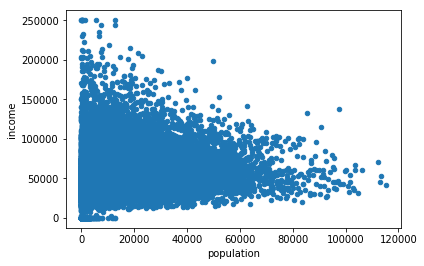

In [153]:
df.plot.scatter(x='population', y='income')

A high percentage of zip codes have very small population. To have a better visualization, eliminate the low population zip codes and use a joint plot from seaborn:

In [19]:
print('{:.1f} percent of zip codes have fewer than 5000 people'.format(100.0 * (df.population < 5000).sum() / len(df)))

60.0 percent of zip codes have fewer than 5000 people


/Users/dillon/Envs/pydata/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


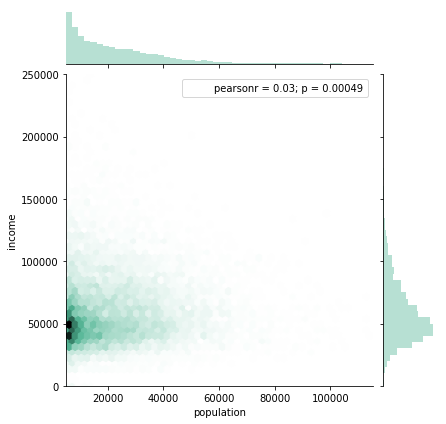

In [18]:
tmp = df[df.population >= 5000]
sns.jointplot(tmp.population, tmp.income, kind="hex", color="#4CB391")

# Nighttime Lights

In [172]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely import geometry
import numpy as np
import scipy.misc

In [173]:
gdf = gpd.read_file(DATA_PATH + '/ZCTA_2010Census_DP1')
gdf['area'] = gdf.geometry.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs').area
gdf['pop_density'] = gdf['DP0010001'] / gdf['area'] * 1000*1000
gdf['log_pop_density'] = gdf.pop_density.map(lambda x: np.log(x))

/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


In [174]:
gdf['log_pop_density'] = gdf.pop_density.map(lambda x: np.log(x))

/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


In [175]:
lower_48_cut = geometry.Polygon([(-125, 50), (-60, 50), (-60,20), (-125, 20)])
lower_48 = gdf[gdf.geometry.intersects(lower_48_cut)]
lower_48 = lower_48[lower_48.pop_density > 0]
lower_48['log_pop_density'] = gdf.pop_density.map(lambda x: np.log(x))
#tmp.plot(column='DP0010001')

/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


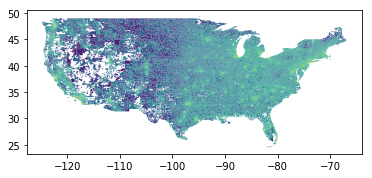

In [176]:
lower_48[lower_48.pop_density > 0].plot(column='log_pop_density')

In [177]:
gdf.shape

(33120, 198)

In [178]:
df.head()

,population,income
86000US00601,17800.0,11507.0
86000US00602,39716.0,15511.0
86000US00603,51565.0,16681.0
86000US00606,6320.0,11648.0
86000US00610,27976.0,17751.0


In [179]:
df.index = df.index.map(lambda x: x[-5:])

In [180]:
tmp = gdf.set_index('GEOID10')
res = tmp[['DP0010001', 'area', 'pop_density', 'geometry']].join(df)

In [181]:
res.head()

,DP0010001,area,pop_density,geometry,population,income
GEOID10,,,,,,
04757,2870,3.383647e+08,8.481973,POLYGON ((-68.08094999999992 46.56745699999999...,2880.0,51036.0
04758,1498,9.119880e+07,16.425655,"POLYGON ((-67.906499 46.52525900000012, -67.90...",1432.0,38967.0
04760,795,2.603353e+08,3.053754,POLYGON ((-67.85272099999997 46.37206700000013...,694.0,36513.0
04975,48,1.423188e+05,337.270891,"POLYGON ((-69.58945 44.62187599999999, -69.589...",132.0,0.0
04976,9903,2.626303e+08,37.706994,POLYGON ((-69.73503399999993 44.78785000000005...,9722.0,32609.0


### Nightlights Rasterio

In [182]:
nightlights = rasterio.open(DATA_PATH + '/F182013.v4c_web.stable_lights.avg_vis.tif')

In [196]:
print(nightlights.crs)

CRS({'init': 'epsg:4326'})


In [184]:
def geom_to_mean_light(geom):
    try:
        out_image, out_transform = mask(nightlights, [geometry.mapping(geom)], crop=True)
        res = out_image.mean()
    except ValueError:
        res = -1
    return res

In [185]:
reproj = res.to_crs(nightlights.crs.to_string())

In [187]:
res['mean_nightlight'] = reproj.geometry.map(geom_to_mean_light)

In [76]:
import seaborn as sns
from scipy.stats import kendalltau

/Users/dillon/Envs/pydata/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


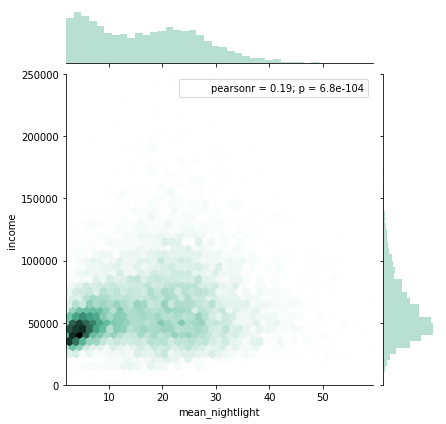

In [118]:
tmp = res[(res.population > 5000)& (res.mean_nightlight > 2)]
sns.jointplot(tmp.mean_nightlight, tmp.income, kind="hex", color="#4CB391")

In [94]:
res.head()

,DP0010001,area,pop_density,geometry,population,income,mean_nightlight
GEOID10,,,,,,,
04757,2870,3.383647e+08,8.481973,POLYGON ((-68.08094999999992 46.56745699999999...,2880.0,51036.0,2.947917
04758,1498,9.119880e+07,16.425655,"POLYGON ((-67.906499 46.52525900000012, -67.90...",1432.0,38967.0,6.166667
04760,795,2.603353e+08,3.053754,POLYGON ((-67.85272099999997 46.37206700000013...,694.0,36513.0,0.863578
04975,48,1.423188e+05,337.270891,"POLYGON ((-69.58945 44.62187599999999, -69.589...",132.0,0.0,0.000000
04976,9903,2.626303e+08,37.706994,POLYGON ((-69.73503399999993 44.78785000000005...,9722.0,32609.0,7.515674


/Users/dillon/Envs/pydata/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


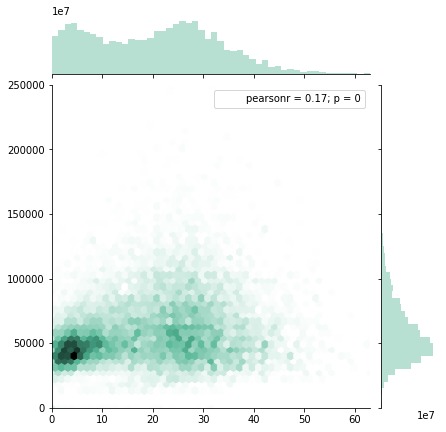

In [188]:
income = np.hstack(res.apply(lambda x: np.repeat(x.income, x.population), axis=1))
mean_nightlights = np.hstack(res.apply(lambda x: np.repeat(x.mean_nightlight, x.population), axis=1))
sns.jointplot(mean_nightlights, income, kind="hex", color="#4CB391")

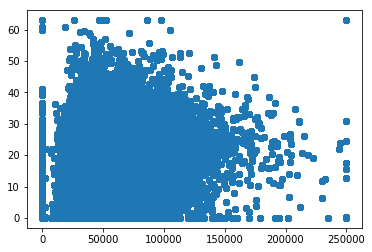

In [193]:
plt.scatter(income, mean_nightlights)

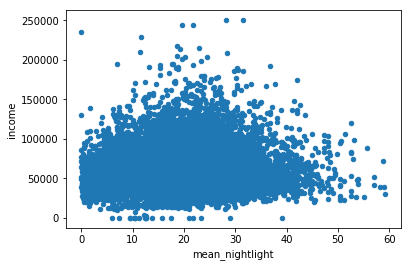

In [71]:
tmp = pd.DataFrame(res)
tmp = tmp[tmp.population > 5000]
tmp.plot.scatter(x='mean_nightlight', y='income')

In [8]:
county = gpd.read_file(DATA_PATH + '/County_2010Census_DP1')

In [9]:
cut_poly = geometry.Polygon([(-125, 50), (-60, 50), (-60,20), (-125, 20)])
county_reduced = county[county.geometry.intersects(cut_poly)]
county_reduced['area'] = county_reduced.geometry.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs').area
county_reduced['pop_density'] = county_reduced['DP0010001'] / county_reduced['area'] * 1000*1000
county_reduced['log_pop_density'] = county_reduced.pop_density.map(lambda x: np.log(x))

/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


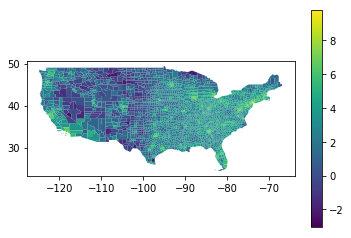

In [8]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
county_reduced['log_pop_density'] = county_reduced.pop_density.map(lambda x: np.log(x))
county_reduced.plot(ax=ax, column='log_pop_density', legend=True)

In [8]:
tmp = county_reduced.geometry.to_crs(nightlights.crs.to_string())
county_reduced['mean_nightlight'] = tmp.geometry.map(geom_to_mean_light)

/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/Users/dillon/Envs/pydata/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


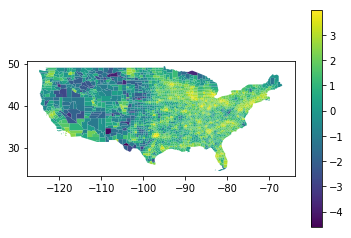

In [11]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
county_reduced['log_nightlight'] = county_reduced.mean_nightlight.map(lambda x: np.log(x))
county_reduced.plot(ax=ax, column='log_nightlight', legend=True)

## Cover image

In [19]:
europe_bbox = geometry.Polygon([(-11, 65), (30, 65), (30,35), (-11, 35)])

In [5]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [20]:
germany = world[world.iso_a3 == 'DEU'].geometry.values[0]
germany_image, out_transform = mask(nightlights, [geometry.mapping(germany)], crop=True)

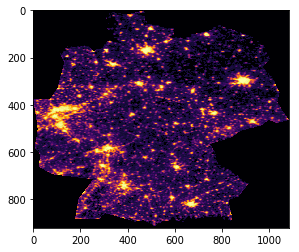

In [21]:
plt.imshow(germany_image[0], cmap='inferno')


In [22]:
plt.imsave('/Users/dillon/Desktop/germany.png', germany_image[0], cmap='inferno')

In [20]:
out_image, out_transform = mask(nightlights, [europe_bbox], crop=True)

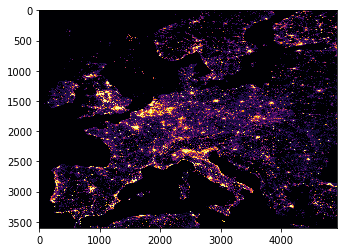

In [25]:
fig, ax = plt.subplots()
ax.imshow(out_image[0], cmap='inferno')

In [28]:
plt.imsave('/Users/dillon/Desktop/europe.png', out_image[0], cmap='inferno')

In [36]:
gdf = gpd.read_file(os.path.join(DATA_PATH, 'DHS/NG_2013_DHS_08212017_1132_110001/ngge6afl/'))

In [37]:
tmp = gdf.geometry.to_crs('+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0').buffer(5000).to_crs(nightlights.crs.to_string())

In [7]:
world.geometry.crs

{'init': 'epsg:4326'}

In [23]:
nigeria_polygon = world.loc[world.iso_a3 == 'NGA', 'geometry'].values[0]
nigeria_image, _ = mask(nightlights, [geometry.mapping(nigeria_polygon)], crop=True)

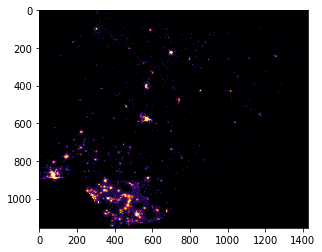

In [195]:
plt.imshow(nigeria_image[0], cmap='inferno')

In [25]:
plt.imsave('/Users/dillon/Desktop/nigeria.png', nigeria_image[0], cmap='inferno')

# Nigeria

In [106]:
nigeria_df = gpd.read_file('/data/PyDataSpatialAnalysis/data/formatted_dhs/')

In [107]:
nigeria_df.shape

(38515, 3)

In [108]:
nigeria_df.geometry.crs

{'init': 'epsg:4326'}

In [109]:
def geom_to_mean_light(geom):
    try:
        out_image, out_transform = mask(nightlights, [geometry.mapping(geom)], crop=True)
        res = out_image.mean()
    except ValueError:
        res = -1
    return res

In [131]:
nigeria_df.head()

,cluster,assets,geometry
0,1.0,-106269,POINT (8.097115000000001 6.90227)
1,1.0,-89171,POINT (8.097115000000001 6.90227)
2,1.0,-101669,POINT (8.097115000000001 6.90227)
3,1.0,-105983,POINT (8.097115000000001 6.90227)
4,1.0,-89785,POINT (8.097115000000001 6.90227)


In [133]:
tmp = nigeria_df.groupby('cluster').agg({'assets': 'median', 'geometry': 'first'})

In [138]:
clusters_ = nigeria_df.groupby('cluster').agg({'assets': 'median', 'geometry': 'first'})
clusters = gpd.GeoDataFrame(clusters_).set_geometry('geometry')
clusters.crs = nigeria_df.crs

In [119]:
nigeria_df.shape
nigeria_df = nigeria_df[nigeria_df.cluster.map(lambda x: x not in clusters_without_location)]

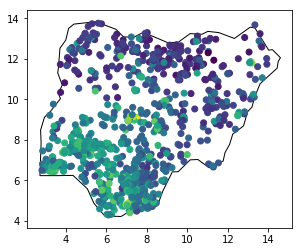

In [144]:
ax = world[world.iso_a3 == 'NGA'].plot(color='white', edgecolor='black')
ax = clusters.plot(ax=ax, column='assets')


In [169]:
clusters['mean_nightlight'] = clusters.to_crs('+proj=utm +zone=32 +ellps=GRS80 +units=m +no_defs ').buffer(500).to_crs("+init=epsg:4326").geometry.map(geom_to_mean_light)

In [170]:
clusters.head()

,assets,geometry,mean_nightlight
cluster,,,
1.0,-93782.0,POINT (8.097115000000001 6.90227),0.0
2.0,-51549.0,POINT (7.876807 7.854454),0.0
3.0,-62769.0,POINT (7.940457 7.781454),0.0
4.0,-26352.5,POINT (9.197081000000001 7.176902),0.0
5.0,-81383.5,POINT (9.164210000000001 7.148612),0.0


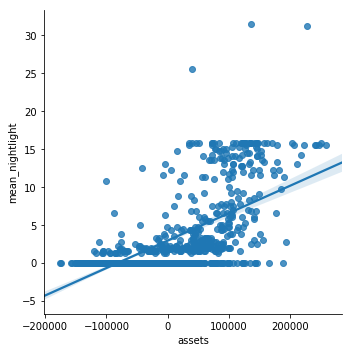

In [171]:
sns.lmplot(y='mean_nightlight', x='assets', data=clusters)